In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import toml
import glob

# Read config and prepare dataset

In [2]:
config = toml.load('config.toml')

In [3]:
save_folder = config['preprocess']['output_folder']
music_data = ''
# print(isinstance(music_data, str))
for data_path in glob.glob(save_folder + '/*.npy'):
    read = np.load(data_path)
    if isinstance(music_data,str):
        music_data = read
    else:
        music_data = np.append(music_data, read, axis=1)

# music_data = np.concatenate(music_data, axis = 1)


In [4]:
normalize = lambda x : (x - x.min()) / (x.max()-x.min())

In [5]:
#normalize the input.
music_data = np.abs(music_data)
music_data = librosa.amplitude_to_db(music_data)
music_data = normalize(music_data)

In [6]:
music_data.max()

1.0

In [7]:
# Data hyperparameters
seq_length = 64
window_stride = 3

# Learning hyperparameters
learning_rate = 0.005
batch_size = 120
input_size = music_data.shape[0]
ds_size = music_data.shape[1]

# Generation hyperparameters
temperature = 0.2 # 0.2 - 1 
num_predictions = 120
# prediction_sample_size = 120


# Create the training dataset

In [8]:
music_ds = tf.data.Dataset.from_tensor_slices(music_data.T)
music_ds.element_spec

2022-01-27 13:04:44.983707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 13:04:45.014793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 13:04:45.015010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 13:04:45.015739: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

TensorSpec(shape=(1025,), dtype=tf.float32, name=None)

In [9]:
def create_training_sequences(dataset: tf.data.Dataset, seq_length: int) -> tf.data.Dataset:
    """Create training sequences and respective labels for training."""
    seq_length += 1
    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=window_stride,
                                drop_remainder=True)
    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)


    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        target = sequences[-1]
        return inputs, target

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)



In [10]:
seq_ds = create_training_sequences(music_ds, seq_length)
seq_ds.element_spec

(TensorSpec(shape=(64, 1025), dtype=tf.float32, name=None),
 TensorSpec(shape=(1025,), dtype=tf.float32, name=None))

In [11]:
buffer_size = ds_size - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE)
            )



In [12]:
train_ds.element_spec

(TensorSpec(shape=(120, 64, 1025), dtype=tf.float32, name=None),
 TensorSpec(shape=(120, 1025), dtype=tf.float32, name=None))

# Create and train the model.

In [13]:

input_shape = (seq_length, input_size)
model = keras.Sequential()
inputs = tf.keras.Input(input_shape)
input_pool = tf.keras.layers.AveragePooling1D()(inputs)
input_rand = tf.keras.layers.GaussianNoise(.1)(input_pool)
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(input_size, return_sequences=True))(input_rand)
x3 = tf.keras.layers.LSTM(input_size, return_sequences=False)(x2)
output = tf.keras.layers.Dense(input_size)(x3)

model = tf.keras.Model(inputs, output)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 1025)]        0         
                                                                 
 average_pooling1d (AverageP  (None, 32, 1025)         0         
 ooling1D)                                                       
                                                                 
 gaussian_noise (GaussianNoi  (None, 32, 1025)         0         
 se)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 32, 2050)         16818200  
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 1025)              12611600  
                                                             

In [14]:
losses = model.evaluate(train_ds, return_dict=True)

2022-01-27 13:04:49.733273: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8300


91/91 [==============================] - 12s 111ms/step - loss: 0.6949


In [15]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]


In [16]:
%%time
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)


Epoch 1/10
91/91 [==============================] - 31s 319ms/step - loss: 0.5452
Epoch 2/10
91/91 [==============================] - 29s 317ms/step - loss: 0.5232
Epoch 3/10
91/91 [==============================] - 29s 318ms/step - loss: 0.5204
Epoch 4/10
91/91 [==============================] - 29s 321ms/step - loss: 0.5199
Epoch 5/10
91/91 [==============================] - 30s 326ms/step - loss: 0.5185
Epoch 6/10
91/91 [==============================] - 30s 325ms/step - loss: 0.5178
Epoch 7/10
91/91 [==============================] - 31s 342ms/step - loss: 0.5193
Epoch 8/10
91/91 [==============================] - 28s 308ms/step - loss: 0.5198
Epoch 9/10
91/91 [==============================] - 29s 324ms/step - loss: 0.5179
Epoch 10/10
91/91 [==============================] - 28s 308ms/step - loss: 0.5179
CPU times: user 4min 45s, sys: 2.79 s, total: 4min 48s
Wall time: 4min 54s


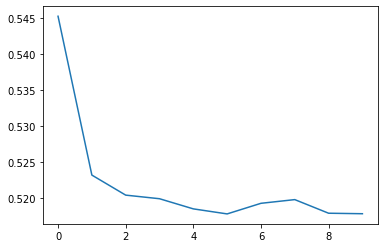

In [17]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [18]:
model.input_shape

(None, 64, 1025)

In [19]:
model.outputs

[<KerasTensor: shape=(None, 1025) dtype=float32 (created by layer 'dense')>]

In [20]:
model.save('model')

2022-01-27 13:09:56.746055: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [21]:
def predict_next(
    inputs: np.ndarray, 
    keras_model: tf.keras.Model, 
    ) -> np.ndarray:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(inputs, 0)
  # random = tf.random.normal(inputs.shape)
  # inputs = inputs * random
  predictions = model.predict(inputs)
  # predictions = inverse_normalization(predictions)
  return predictions


In [22]:
import random

note_start = random.randint(0, len(music_data.T)-seq_length-1)
sample = music_data[:,note_start:note_start+seq_length].T

generated_notes = []

for i in range(num_predictions):
    prediction = predict_next(sample, model)
    generated_notes.append(prediction)
    sample = np.delete(sample, 0, axis=0)
    sample = np.append(sample, prediction, axis=0)
generated_notes = np.concatenate(generated_notes)

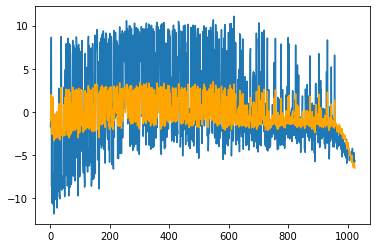

In [23]:
plt.plot(generated_notes[21])
plt.plot(generated_notes[25],color='orange')

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

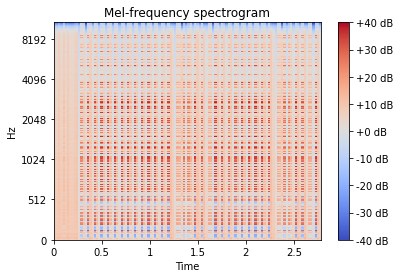

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
generated_notes = normalize(generated_notes) * 80 - 40


# print(generated_notes.min())

img = librosa.display.specshow(generated_notes.T, x_axis='time',

                         y_axis='mel', sr=22050,

                        ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')

ax.set(title='Mel-frequency spectrogram')


In [25]:
import librosa.feature
if config['preprocess']['feature_extraction'] == 'mel':
    A = librosa.feature.inverse.mel_to_audio(generated_notes)
elif config['preprocess']['feature_extraction'] == 'mfcc':
    A = librosa.feature.inverse.mfcc_to_audio(generated_notes)
elif config['preprocess']['feature_extraction'] == 'stft':
    A = librosa.griffinlim(generated_notes)

In [26]:
import IPython.display as ipd
ipd.Audio(A, rate=22050)